In [1]:
#from scipy import stats
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#%matplotlib inline
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm
import corner
import emcee

(86964, 20)
1965


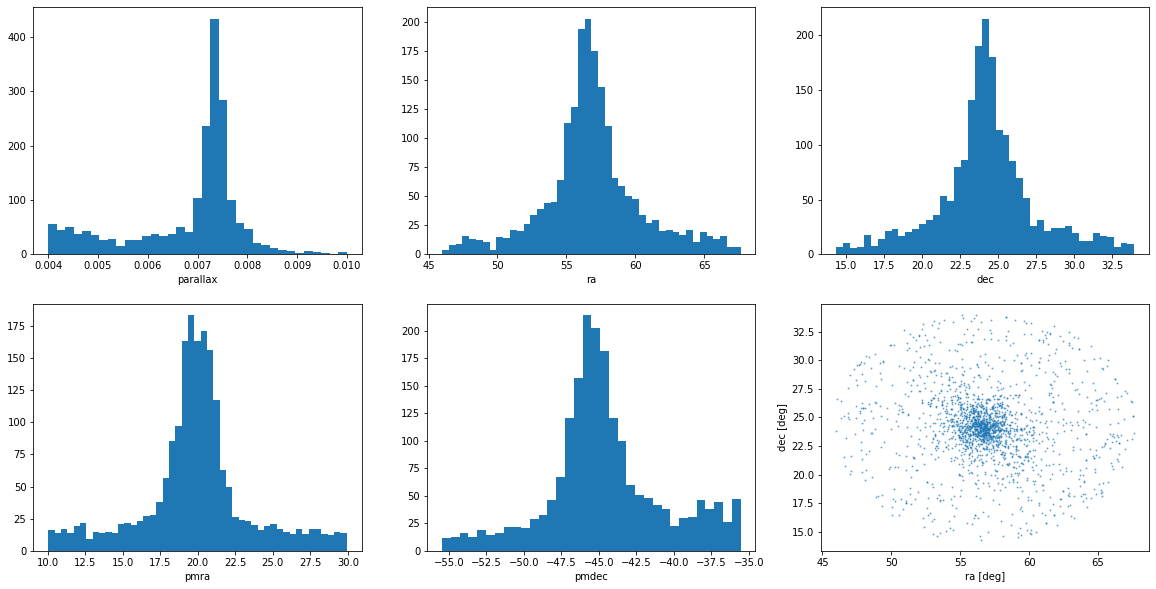

In [31]:
df = pd.read_csv('./data.csv')
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(df.parallax,bins='auto')
plt.xlabel('parallax')

plt.subplot(2,3,2)
plt.hist(df.ra,bins='auto')
plt.xlabel('ra')

plt.subplot(2,3,3)
plt.hist(df.dec,bins='auto')
plt.xlabel('dec')

plt.subplot(2,3,4)
plt.hist(df.pmra,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmra')

plt.subplot(2,3,5)
plt.hist(df.pmdec,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmdec')

plt.subplot(2,3,6)
plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
plt.xlabel("ra [deg]")
plt.ylabel("dec [deg]")#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
plt.show()

In [10]:
def gaussian_function(x, params):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    return nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)

def log_likelihood(params, x):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    y = nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)
    # Calculate log likelihood
    return np.sum(np.log(y))

def log_prior(params):
    nc, sc, sf, mu_c, mu_f = params
    if 0.0 < nc < 1.0 and 0.0 < sc < 10.0 and 0.0 < sf < 10.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

nll = lambda *args: -log_likelihood(*args)

def get_gelman_rubin(chain):
    ssq = np.var(chain, axis=1, ddof=1)
    W = np.mean(ssq, axis=0)
    theta_mean = np.mean(chain, axis=1)
    theta_m = np.mean(theta_mean, axis=0)
    M = chain.shape[0]
    N = chain.shape[1]
    B = N / (M - 1) * np.sum((theta_m - theta_mean)**2, axis=0)
    V = (N - 1) / N * W + 1 / N * B
    R = np.sqrt(V / W)
    return R

In [5]:
sample_data = df.pmra
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmra = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmra, sample_data))
print(log_prior(initparams_pmra))
print(log_probability(initparams_pmra, sample_data))

results_pmra = minimize(nll, initparams_pmra, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmra.x

-5231.594395211177
0.0
-5231.594395211177


array([ 0.48829093,  1.03814666,  4.98350399, 19.93836987, 19.8259093 ])

In [6]:
sample_data = df.pmdec
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmdec = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmdec, sample_data))
print(log_prior(initparams_pmdec))
print(log_probability(initparams_pmdec, sample_data))

results_pmdec = minimize(nll, initparams_pmdec, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmdec.x

-5478.562789421741
0.0
-5478.562789421741


array([  0.37604539,   1.07247782,   4.83730377, -45.45737134,
       -44.12901859])

Text(0.5, 0, 'pmdec')

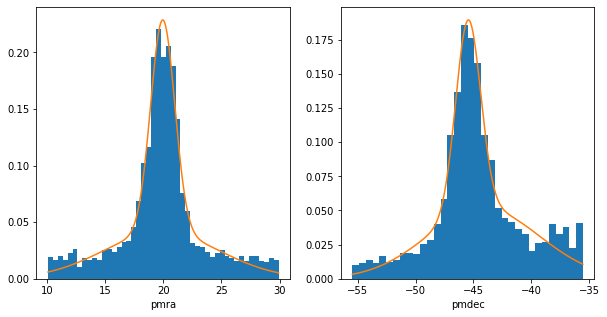

In [7]:
plt.figure(figsize=(10,5))
sample_data = df.pmra
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmra.x))
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmdec.x))
plt.xlabel('pmdec')

In [8]:
sample_data = df.pmra
n_walkers, n_dim = 100, 5
p0 = results_pmra.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler_pmra = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[sample_data])
pos, prob, state = sampler_pmra.run_mcmc(p0, 1000, progress = True)

100%|██████████| 1000/1000 [02:58<00:00,  5.59it/s]


Text(0.5, 0, 'step number')

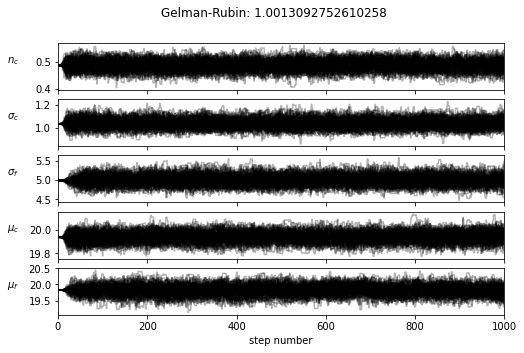

In [13]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
samples = sampler_pmra.get_chain()
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
fig.suptitle('Gelman-Rubin: {}'.format(get_gelman_rubin(samples)[0]))
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

Minimize: [ 0.48829093  1.03814666  4.98350399 19.93836987 19.8259093 ]
MCMC:     [ 0.48780997  1.04343124  5.01043109 19.94911858 19.80697718]
(6000, 5)


<Figure size 576x576 with 0 Axes>

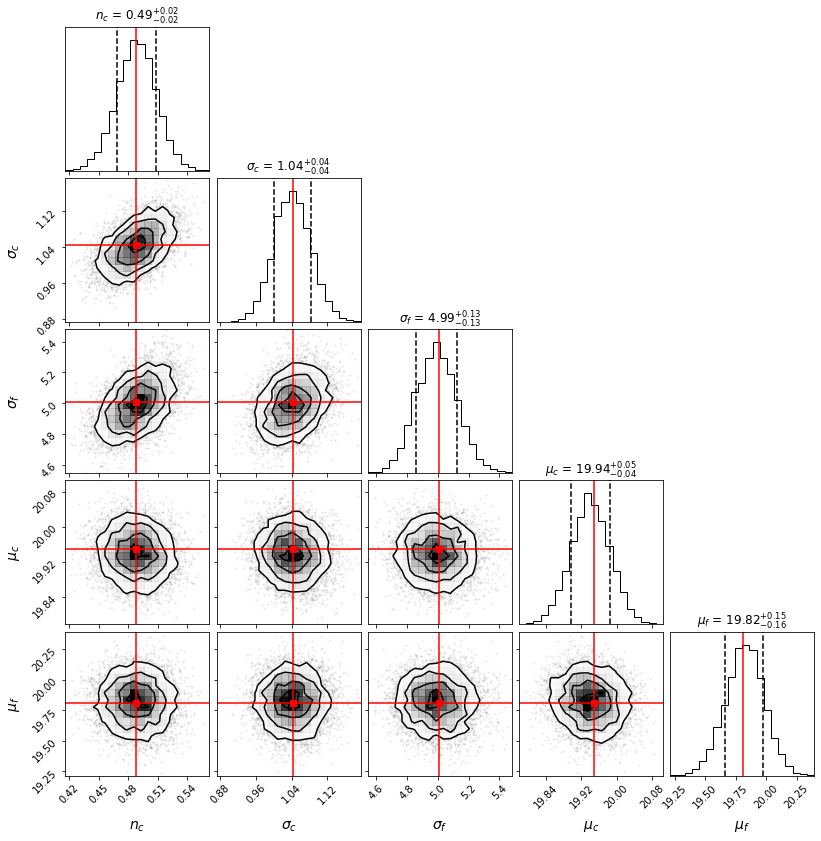

In [15]:
#tau = sampler.get_autocorr_time()
#print(tau)

params_mcmc_pmra = np.percentile(pos ,50, axis=0)
print('Minimize:',results_pmra.x)
print('MCMC:    ',params_mcmc_pmra)

flat_samples = sampler_pmra.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

truths = params_mcmc_pmra
plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12},label_kwargs=dict(fontsize=14),truth_color='red')

In [16]:
sample_data = df.pmdec
n_walkers, n_dim = 100, 5
p0 = results_pmdec.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler_pmdec = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[sample_data])
pos, prob, state = sampler_pmdec.run_mcmc(p0, 1000, progress = True)

100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


Text(0.5, 0, 'step number')

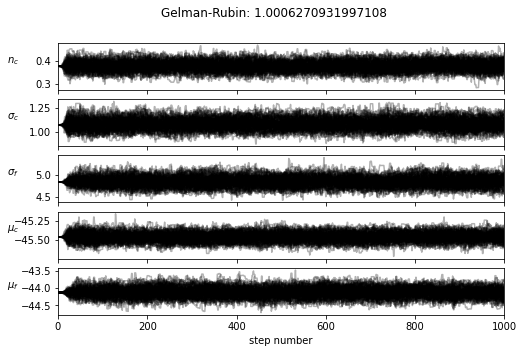

In [17]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
samples = sampler_pmdec.get_chain()
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
fig.suptitle('Gelman-Rubin: {}'.format(get_gelman_rubin(samples)[0]))
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

Minimize: [  0.37604539   1.07247782   4.83730377 -45.45737134 -44.12901859]
MCMC:     [  0.3790332    1.0835905    4.85043454 -45.45745993 -44.14168003]
(6000, 5)


<Figure size 576x576 with 0 Axes>

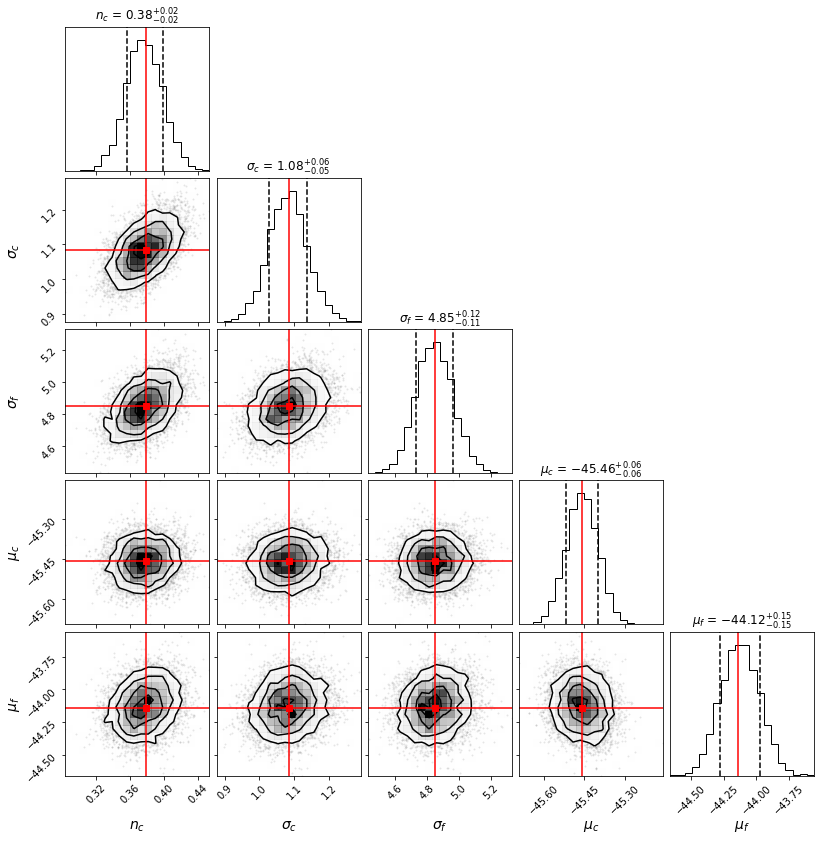

In [18]:
#tau = sampler.get_autocorr_time()
#print(tau)

params_mcmc_pmdec = np.percentile(pos ,50, axis=0)
print('Minimize:',results_pmdec.x)
print('MCMC:    ',params_mcmc_pmdec)

flat_samples = sampler_pmdec.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

truths = params_mcmc_pmdec
plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12},label_kwargs=dict(fontsize=14),truth_color='red')

Text(0.5, 0, 'pmdec')

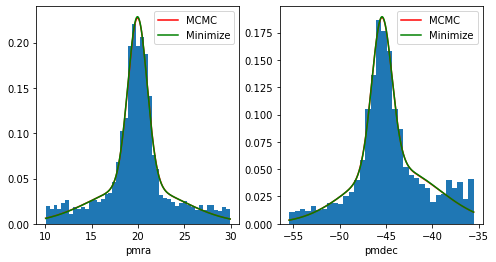

In [19]:
sample_data = df.pmra
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmra), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmra.x), label='Minimize', color='green')
plt.legend()
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmdec), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmdec.x), label='Minimize',color='green')
plt.legend()
plt.xlabel('pmdec')

In [20]:
def log_prior(params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    if 0.0 < nc < 1.0 and 0.0 < s < 10.0 and 0.0 < sx < 10.0 and 0.0 < sy < 10.0 and -1.0 < rho < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(params, x, y):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    # Calculate log likelihood
    return np.sum(np.log(z))

def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

In [21]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
rho_matrix = np.corrcoef(df.pmra, df.pmdec)
initparams = [0.5, results_pmra.x[1], results_pmra.x[2], results_pmdec.x[2], rho_matrix[0][1],
       results_pmra.x[3], results_pmdec.x[3], results_pmra.x[4], results_pmdec.x[4]]
print(initparams)
print(log_likelihood(initparams, x, y))
print(log_prior(initparams))
print(log_probability(initparams, x, y))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(x, y), options={"disc":True}, method='Nelder-Mead')
results.x

[0.5, 1.038146655237542, 4.983503993721438, 4.83730376754177, -0.14073419454276265, 19.9383698667556, -45.45737134256799, 19.825909303867967, -44.12901859117876]
-10019.223863088484
0.0
-10019.223863088484


array([  0.47772208,   1.1112222 ,   4.93604621,   5.21740536,
        -0.13975546,  19.94654804, -45.41058935,  19.8206177 ,
       -43.91303715])

In [22]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf

n_walkers, n_dim = 100, 9
p0 = results.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[x, y])
pos, prob, state = sampler.run_mcmc(p0, 5000, progress = True)

100%|██████████| 5000/5000 [28:50<00:00,  2.89it/s]


Text(0.5, 0, 'step number')

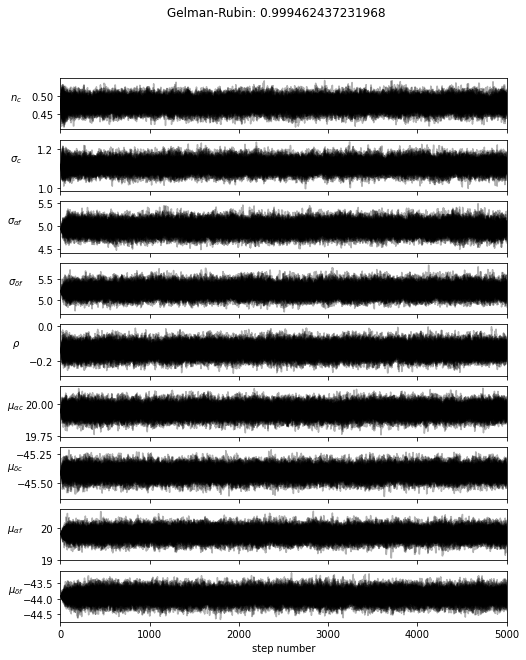

In [23]:
fig, axes = plt.subplots(n_dim, figsize=(8, 10), sharex=True)
samples = sampler.get_chain()
labels = ["$n_c$", "$\sigma_c$", "$\sigma_{\\alpha f}$", "$\sigma_{\delta f}$", "$\\rho$",
          "$\mu_{\\alpha c}$", "$\mu_{\delta c}$", "$\mu_{\\alpha f}$", "$\mu_{\delta f}$"]
fig.suptitle('Gelman-Rubin: {}'.format(get_gelman_rubin(samples)[0]))
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

Minimize: [  0.47772208   1.1112222    4.93604621   5.21740536  -0.13975546
  19.94654804 -45.41058935  19.8206177  -43.91303715]
MCMC:     [  0.48121875   1.11007401   4.94932021   5.26007658  -0.14259887
  19.94651651 -45.41887466  19.81800945 -43.94619899]
(32600, 9)


<Figure size 576x576 with 0 Axes>

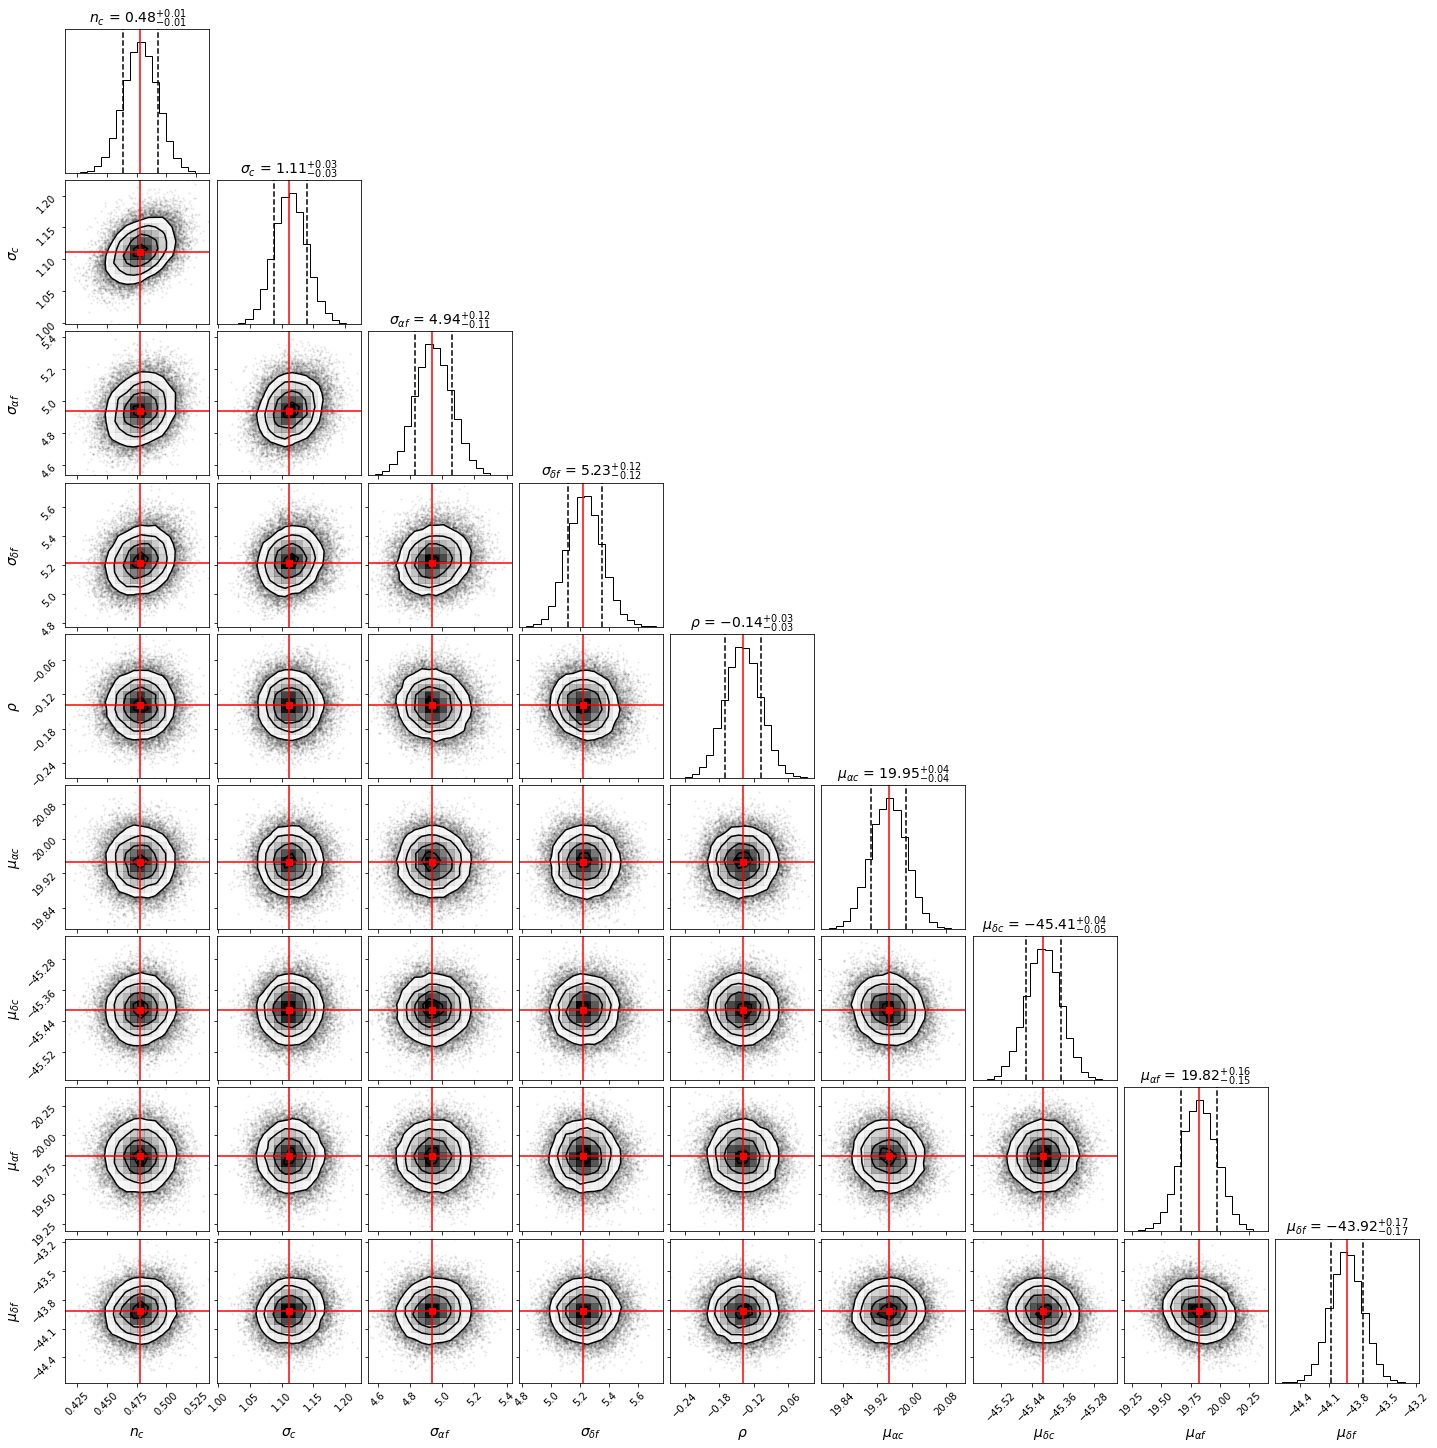

In [24]:
params_mcmc = np.percentile(pos ,50, axis=0)
#maxprob_indice = np.argmax(prob)
#params_mcmc = pos[maxprob_indice]
print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
truths = results.x#params_mcmc

plt.figure(figsize=(8,8)) #quantiles=[0.16, 0.5, 0.84]
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 14},label_kwargs=dict(fontsize=14),truth_color='red')
#rasterized=True
#plt.savefig('./corner.jpg',bbox_inches = "tight")

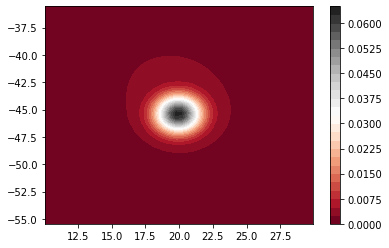

In [25]:
x = np.linspace(min(df.pmra), max(df.pmra), 50)
y = np.linspace(min(df.pmdec), max(df.pmdec), 50)

def func(x, y, params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    return z

X, Y = np.meshgrid(x, y)
Z = func(X, Y, results.x)

plt.contourf(X, Y, Z, 30, cmap='RdGy')
plt.colorbar()

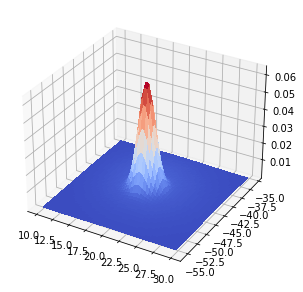

In [26]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(5, 5))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

Min: 0.0000000000 Max: 0.9516959667


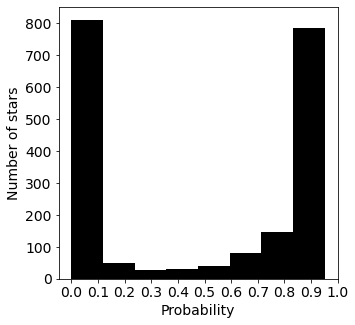

In [27]:
#nf, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = truths
nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = results.x

def probabilidad_circ(xy, nc, s, mu_xc, mu_yc):
    x, y = xy
    amp_circ =  1 / (2 * np.pi * s**2)
    Exp_circ = - 1/2 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    return nc * amp_circ * np.exp(Exp_circ)

def probabilidad_elip(xy, nc, sx, sy, rho, mu_xf, mu_yf):
    x, y = xy
    amp_elip = 1 / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_elip = - 1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    return (1-nc) * amp_elip * np.exp(Exp_elip)

xy = np.vstack((df.pmra, df.pmdec))
param_circ_prob = (nc, s, mu_xc, mu_yc)
param_elip_prob = (nc, sx, sy, rho, mu_xf, mu_yf)
p_circ = probabilidad_circ(xy, *param_circ_prob)
p_elip = probabilidad_elip(xy, *param_elip_prob)
prob = p_circ / (p_circ + p_elip)
print('Min: {:.10f} Max: {:.10f}'.format(min(prob), max(prob)))

plt.figure(figsize=(5,5))
plt.hist(prob, bins=8,range=[min(prob), max(prob)],color='black')#histtype='step'
plt.xlabel('Probability',fontsize=14)
plt.ylabel('Number of stars',fontsize=14)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.savefig('./results/probabilities.jpg',bbox_inches = "tight")
plt.show()

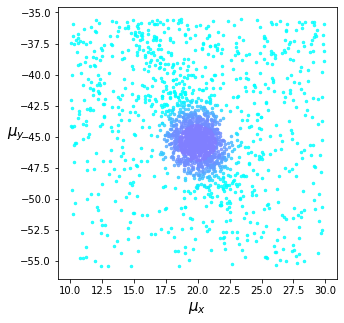

In [28]:
#colors=['black','dimgray','darkgrey','gainsboro','wheat','rosybrown','lightcoral','indianred','salmon','red']
#loop = np.arange(0.0, 1.0, 0.1)
loop = np.arange(0.0, 1.0, 0.1)
colors = [plt.cm.cool(each) for each in np.linspace(0, 0.5, len(loop))]

plt.figure(figsize=(5,5))
for i,c in zip(loop, colors):
  cond = (prob >= i) & (prob < i + 0.1)
  pmra_, pmdec_ = df.pmra[(cond)], df.pmdec[(cond)]
  plt.plot(pmra_, pmdec_,marker='.',c=c,linestyle='None',markersize=5,alpha=0.8)
plt.xlabel("$\mu_{x}$", fontsize = 15)
plt.ylabel("$\mu_{y}$", fontsize = 15,rotation=0)
#plt.savefig('./VPDClasses.jpg')
plt.show()

In [29]:
prob_limit = 0.5
members = (prob >= prob_limit)
no_members = (prob < prob_limit)

df['probability'] = prob
cluster_members = df[members]
#cluster_members.to_csv('./members_pm.csv')
print(len(cluster_members))
cluster_members

1041


,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,g,g_error,rp,rp_error,bp,bp_error,rv,rv_error,ruwe,probability
175,63449521800719488,55.773982,0.079372,21.030220,0.058686,0.007661,0.000102,19.368667,0.119068,-46.283156,...,17.138874,2.743944,15.843201,15.539463,19.031832,7.887697,0.000000,0.000000,0.984827,0.931537
345,63502259702709888,56.383383,0.026597,21.246480,0.020065,0.007748,0.000029,20.652807,0.036001,-47.762058,...,7.728319,5213.427200,7.562601,3090.533700,7.804670,7282.456000,1.567685,0.736016,1.043121,0.683950
371,63507860340462208,56.593062,0.223397,21.088765,0.156204,0.007590,0.000266,20.472016,0.275824,-46.552291,...,18.534664,1.763879,17.123377,11.337543,20.782875,6.528066,0.000000,0.000000,0.999825,0.919002
467,63527827643105408,56.532550,0.173796,21.345159,0.133183,0.007235,0.000185,19.009062,0.237064,-45.063595,...,18.706327,1.449828,17.319443,10.996151,20.768375,5.878046,0.000000,0.000000,0.955010,0.929415
469,65588484235454592,58.268967,0.013425,22.801153,0.008666,0.007293,0.000015,19.036700,0.017368,-45.560948,...,13.100869,73.891630,12.250756,178.715670,13.850247,130.469680,6.250218,0.944959,1.044438,0.934938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79154,122022121119845120,47.906911,0.221332,28.792018,0.182254,0.004251,0.000256,19.314525,0.348698,-43.723746,...,18.650220,1.511869,17.374552,11.072809,20.266167,6.969432,0.000000,0.000000,1.037522,0.836196
79978,120566642602294144,51.571820,0.085602,29.402625,0.058282,0.006924,0.000095,21.107899,0.112349,-43.942702,...,16.907210,2.888820,15.617982,18.219112,18.731787,10.021989,0.000000,0.000000,1.021745,0.825562
81087,118934589389853184,51.590114,0.029944,28.263745,0.021326,0.004034,0.000035,19.387904,0.039339,-46.781893,...,15.056710,5.674553,14.105474,21.522924,15.984642,11.904441,24.257010,8.191830,1.065136,0.901657
81881,122390663673320832,49.426275,0.104858,29.955577,0.094223,0.005972,0.000122,17.457539,0.137637,-46.608120,...,17.744999,2.658303,16.477583,12.547961,19.632704,11.056532,0.000000,0.000000,0.961607,0.534342


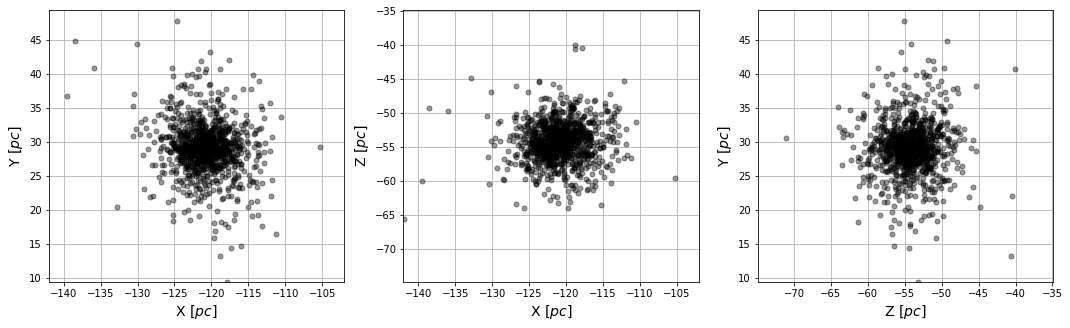

In [30]:
import astropy.units as u
import astropy.coordinates as apycoords

df_test = cluster_members

ra_ = df_test['ra'] *u.deg
dec_ = df_test['dec'] *u.deg
distance_ = np.array(1/df_test['parallax']) *u.pc

c = apycoords.SkyCoord(ra=ra_,dec=dec_,distance=distance_,frame='icrs')
#print("(X,Y,Z) in (kpc,kpc,kpc)")
#print("\t",c.galactic.cartesian)
x = c.galactic.cartesian.x
y = c.galactic.cartesian.y
z = c.galactic.cartesian.z

xp = np.mean(x.to_value())
yp = np.mean(y.to_value())
zp = np.mean(z.to_value())
value = 20

%matplotlib inline
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(x, y,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(xp - value,xp + value)
plt.ylim(yp - value,yp + value)
plt.xlabel("X $[pc]$", fontsize = 14)
plt.ylabel("Y $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()

plt.subplot(1,3,2)
plt.plot(x, z,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(xp - value,xp + value)
plt.ylim(zp - value,zp + value)
plt.xlabel("X $[pc]$", fontsize = 14)
plt.ylabel("Z $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()

plt.subplot(1,3,3)
plt.plot(z, y,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(zp - value,zp + value)
plt.ylim(yp - value,yp + value)
plt.xlabel("Z $[pc]$", fontsize = 14)
plt.ylabel("Y $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()
#plt.savefig('./results/distribucion_espacial_test.jpg')
plt.show()